[View in Colaboratory](https://colab.research.google.com/github/zeinsh/experementaldataprocessing/blob/master/l2_norm0_005.ipynb)

# Face Recognition

<table>
  <tr><td><B>Optimizer</B></td><td>Adam</td></tr>
  <tr><td><B>Loss function</B></td><td>sparse_categorical_crossentropy</td></tr>
  <tr><td><B>Quality Metric</B></td><td>Accuracy</td></tr>
</table>

<B>Basemodel + l2 norm regularization</B><br/>
l2-norm regulizer = 0.005<br/><br/>

<B>Neural Network Architecture:</B>

- input layer
  - Input size 150x150
- First Layer
  - Convolution Layer: 
    - number of filters = 32
    - Filter size = 3x3
    - activation: ReLU
  - Pooling layer
    - size = 2x2
- Second Layer
  - Convolution Layer: 
    - number of filters = 32
    - Filter size = 3x3
    - activation: ReLU
  - Pooling layer
    - size = 2x2
- Third Layer
  - Convolution Layer: 
    - number of filters = 64
    - Filter size = 3x3
    - activation: ReLU
  - Pooling layer
    - size = 2x2
- Dense Layer 1
  - number of neurons = 64
  - activation = ReLU
- output Layer  (Dense)
  - number of neurons = identities_count
  - activation = sigmoid

In [0]:
!pip install -q imutils

In [2]:
## Essentials
import numpy as np
import imutils
import argparse
import cv2
import os                                                                                                             
import random
from PIL import Image
import matplotlib.image as mpimg
from math import ceil
import matplotlib.pyplot as plt
# from skimage.feature import hog


## Keras
from keras.models import Model, load_model
from keras.layers import *
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import ZeroPadding2D

## Analysis
from sklearn import preprocessing
from sklearn.metrics import accuracy_score,f1_score

# Add-ons
# from tqdm import tqdm
# from keras_tqdm import TQDMNotebookCallback

## Path Delimiter depending on os
path_delimiter = os.sep

Using TensorFlow backend.


In [3]:
# download dataset
# dataset path: http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz
!wget http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz

--2018-05-10 11:53:27--  http://vision.seas.harvard.edu/pubfig83/pubfig83.v1.tgz
Resolving vision.seas.harvard.edu (vision.seas.harvard.edu)... 54.165.123.1
Connecting to vision.seas.harvard.edu (vision.seas.harvard.edu)|54.165.123.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38317991 (37M) [application/x-gzip]
Saving to: ‘pubfig83.v1.tgz’

pubfig83.v1.tgz     100%[===================>]  36.54M  23.6MB/s    in 1.5s    

2018-05-10 11:53:28 (23.6 MB/s) - ‘pubfig83.v1.tgz’ saved [38317991/38317991]



In [0]:
!tar -xzf pubfig83.v1.tgz

In [5]:
def list_files(dir_name):
    r = []
    for root, dirs, files in os.walk(dir_name):
        for name in files:
            r.append(os.path.join(root, name))
    return r

def dirs_count(dir_name):
    import os
    return len(next(os.walk(dir_name))[1])

DATASET_PATH = 'pubfig83'
image_paths=list_files(DATASET_PATH)
print(len(image_paths))

13838


In [0]:
def get_eye_center(eye_rect):
    x,y,w,h = eye_rect
    return int(x + w / 2), int(y + h / 2)

class FaceAligner:
    def __init__(self, desiredLeftEye=(0.35, 0.35),
        desiredFaceWidth=256, desiredFaceHeight=None):
        # store the facial landmark predictor, desired output left
        # eye position, and desired output face width + height
        self.desiredLeftEye = desiredLeftEye
        self.desiredFaceWidth = desiredFaceWidth
        self.desiredFaceHeight = desiredFaceHeight

        # if the desired face height is None, set it to be the
        # desired face width (normal behavior)
        if self.desiredFaceHeight is None:
            self.desiredFaceHeight = self.desiredFaceWidth

    def align(self, image, gray, eyes_rects):

        # extract the left and right eye (x, y)-coordinates
        leftEyePts, rightEyePts = eyes_rects

        # compute the center of mass for each eye
        leftEyeCenter = get_eye_center(leftEyePts)
        rightEyeCenter = get_eye_center(rightEyePts)

        # compute the angle between the eye centroids
        dY = rightEyeCenter[1] - leftEyeCenter[1]
        dX = rightEyeCenter[0] - leftEyeCenter[0]
        angle = np.degrees(np.arctan2(dY, dX)) - 180

        # compute the desired right eye x-coordinate based on the
        # desired x-coordinate of the left eye
        desiredRightEyeX = 1.0 - self.desiredLeftEye[0]

        # determine the scale of the new resulting image by taking
        # the ratio of the distance between eyes in the *current*
        # image to the ratio of distance between eyes in the
        # *desired* image
        dist = np.sqrt((dX ** 2) + (dY ** 2))
        desiredDist = (desiredRightEyeX - self.desiredLeftEye[0])
        desiredDist *= self.desiredFaceWidth
        scale = desiredDist / dist

        # compute center (x, y)-coordinates (i.e., the median point)
        # between the two eyes in the input image
        eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

        # grab the rotation matrix for rotating and scaling the face
        M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

        # update the translation component of the matrix
        tX = self.desiredFaceWidth * 0.5
        tY = self.desiredFaceHeight * self.desiredLeftEye[1]
        M[0, 2] += (tX - eyesCenter[0])
        M[1, 2] += (tY - eyesCenter[1])

        # apply the affine transformation
        (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
        output = cv2.warpAffine(image, M, (w, h),
            flags=cv2.INTER_CUBIC)

        # return the aligned face
        return output

In [7]:
!wget https://raw.githubusercontent.com/shantnu/FaceDetect/master/haarcascade_frontalface_default.xml
!wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

--2018-05-10 11:53:34--  https://raw.githubusercontent.com/shantnu/FaceDetect/master/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  4.96MB/s    in 0.2s    

2018-05-10 11:53:34 (4.96 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]

--2018-05-10 11:53:35--  https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request 

In [0]:
# Initializing Face Detector 
# Create the haar cascade
cascPath    = 'haarcascade_frontalface_default.xml'
cascEyePath = 'haarcascade_eye.xml'
faceCascadeDetector = cv2.CascadeClassifier(cascPath)
eyeCascadeDetector  = cv2.CascadeClassifier(cascEyePath)

fa = FaceAligner(desiredFaceWidth=150)

def get_point_rect_respective_pos(point, rect):
    rect_x, rect_y, rect_width, rect_height = rect
    point_x, point_y = point
    return [(point_x - rect_x) / rect_width, (point_y - rect_y) / rect_height]
    

def prepare_eyes_rects(eyes, face_rect):
    '''
    Right eye first
    Check the X-coordinate
    Leave only the leftmost and the rightmost rects
    Use heuristic for simplicity
    '''
    left_eye_min_x_pos = 0
    left_eye_max_x_pos = 0.4
    left_eye_min_y_pos = 0.3
    left_eye_max_y_pos = 0.5
    
    right_eye_min_x_pos = 0.6
    right_eye_max_x_pos = 1.0
    right_eye_min_y_pos = 0.3
    right_eye_max_y_pos = 0.5
    
    left_eye = right_eye = None
    for eye in eyes:
        eye_center = get_eye_center(eye)
        respective_pos = get_point_rect_respective_pos(eye_center, face_rect)
        if (left_eye is None or left_eye[0] > eye[0]) \
            and left_eye_min_x_pos <= respective_pos[0] <= left_eye_max_x_pos \
            and left_eye_min_y_pos <= respective_pos[1] <= left_eye_max_y_pos:
            left_eye = eye
        if (right_eye is None or right_eye[0] < eye[0]) \
            and right_eye_min_x_pos <= respective_pos[0] <= right_eye_max_x_pos \
            and right_eye_min_y_pos <= respective_pos[1] <= right_eye_max_y_pos:
            right_eye = eye
    
    if right_eye is None or left_eye is None:
        return None
    return [right_eye, left_eye]

def faceAlign(image):
    image = imutils.resize(image, width=150)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    rects = faceCascadeDetector.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    eyes = eyeCascadeDetector.detectMultiScale(gray, minNeighbors=1, minSize=(10, 10))
    
    if len(eyes) < 2 or len(rects) != 1:
        return None
    
    face_rect = rects[0]
    eyes = prepare_eyes_rects(eyes, face_rect)
    if eyes is None:
        return None
    
    faceAligned = fa.align(image, gray, eyes)
    
    return faceAligned

In [0]:
sample_image_path = image_paths[0]
sample_image = mpimg.imread(sample_image_path)
sample_image = imutils.resize(sample_image, width=150)

faceAligned = faceAlign(sample_image)

## Sample for Feature Exploration Later
if faceAligned is not None:
    plt.imshow(faceAligned)


In [10]:
## Label Encoder for string Labels

# Finding unique labels
all_labels = [imag.split(path_delimiter)[-2] for imag in image_paths];

## Encoding them
le = preprocessing.LabelEncoder()
le.fit(all_labels)
labels_enc = le.transform(all_labels)

unique_labels = list(le.classes_)
print('Labels: ')
[print(int(le.transform([label])),label) for label in unique_labels];

Labels: 
0 Adam Sandler
1 Alec Baldwin
2 Angelina Jolie
3 Anna Kournikova
4 Ashton Kutcher
5 Avril Lavigne
6 Barack Obama
7 Ben Affleck
8 Beyonce Knowles
9 Brad Pitt
10 Cameron Diaz
11 Cate Blanchett
12 Charlize Theron
13 Christina Ricci
14 Claudia Schiffer
15 Clive Owen
16 Colin Farrell
17 Colin Powell
18 Cristiano Ronaldo
19 Daniel Craig
20 Daniel Radcliffe
21 David Beckham
22 David Duchovny
23 Denise Richards
24 Drew Barrymore
25 Dustin Hoffman
26 Ehud Olmert
27 Eva Mendes
28 Faith Hill
29 George Clooney
30 Gordon Brown
31 Gwyneth Paltrow
32 Halle Berry
33 Harrison Ford
34 Hugh Jackman
35 Hugh Laurie
36 Jack Nicholson
37 Jennifer Aniston
38 Jennifer Lopez
39 Jennifer Love Hewitt
40 Jessica Alba
41 Jessica Simpson
42 Joaquin Phoenix
43 John Travolta
44 Julia Roberts
45 Julia Stiles
46 Kate Moss
47 Kate Winslet
48 Katherine Heigl
49 Keira Knightley
50 Kiefer Sutherland
51 Leonardo DiCaprio
52 Lindsay Lohan
53 Mariah Carey
54 Martha Stewart
55 Matt Damon
56 Meg Ryan
57 Meryl Streep
58 

In [0]:
def augment_brightness_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image1 = np.array(image1, dtype = np.float64)
    random_bright = .6+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1[:,:,2][image1[:,:,2]>255]  = 255
    image1 = np.array(image1, dtype = np.uint8)
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

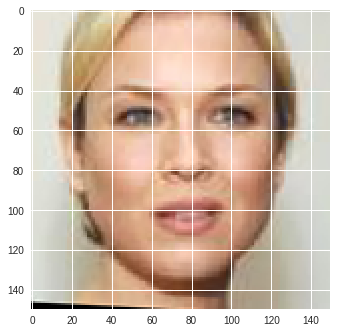

In [12]:
# for data_cropped folder

def read_images(image_paths):
    images = [];
    labels = [];
    for img_path in image_paths:
        try:
          image = faceAlign(mpimg.imread(img_path));
        except Exception as e:
            continue
        if image is not None and np.shape(np.shape(image)) == (3, ):
            images.append(image)
            labels.append(img_path.split(path_delimiter)[1])
    return images,labels


sample_length = 15
image_paths=list_files(DATASET_PATH)
sample_dt=random.sample(image_paths,int(sample_length))
images,labels=read_images(sample_dt)

## Test image reading
image = images[0]
plt.imshow(image);

In [0]:
## Send image_paths of the data_cropped folder
ALIGNED_DATASET_PATH = 'pubfig_aligned'
def save_align_imgs(image_paths):
    for img_path in image_paths:
        try:
            image = faceAlign(mpimg.imread(img_path));
        except:
            continue
        folder = img_path.split(path_delimiter)[-2]
        filename = img_path.split(path_delimiter)[-1]

        if image is not None and np.shape(np.shape(image)) == (3, ):
            if not os.path.exists(ALIGNED_DATASET_PATH+'/'+folder): os.makedirs(ALIGNED_DATASET_PATH+'/'+folder)
            save_image_path = "{}/{}/{}.jpg".format(ALIGNED_DATASET_PATH, folder,filename)
            cv2.imwrite(save_image_path, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

In [0]:
if not os.path.exists(ALIGNED_DATASET_PATH):
    save_align_imgs(image_paths)

In [0]:
# read_images fnc for 'data_aligned' images folder

def read_images_align(image_paths , mod_algo = 0):
    images = [];
    labels = [];
    for img_path in image_paths:
        image = mpimg.imread(img_path)
        images.append(image)
        labels.append(img_path.split(path_delimiter)[1])
    
    if mod_algo:
        ## Modified algorithm to augment brightness. Base Model Does not use modified Algorithm
        sz_img = np.array(images).shape[0]
        ind = (np.random.choice(sz_img, int(sz_img/3), replace=False)).astype(int)
        for n in ind:
            images[n] = augment_brightness_images(images[n])
    
    return images,labels

Shape of the image array:  (50, 1, 150, 150)
Shape of the image:  (1, 150, 150)
Shape of image after reshaping:  (150, 150)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

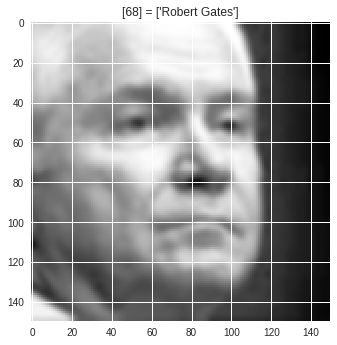

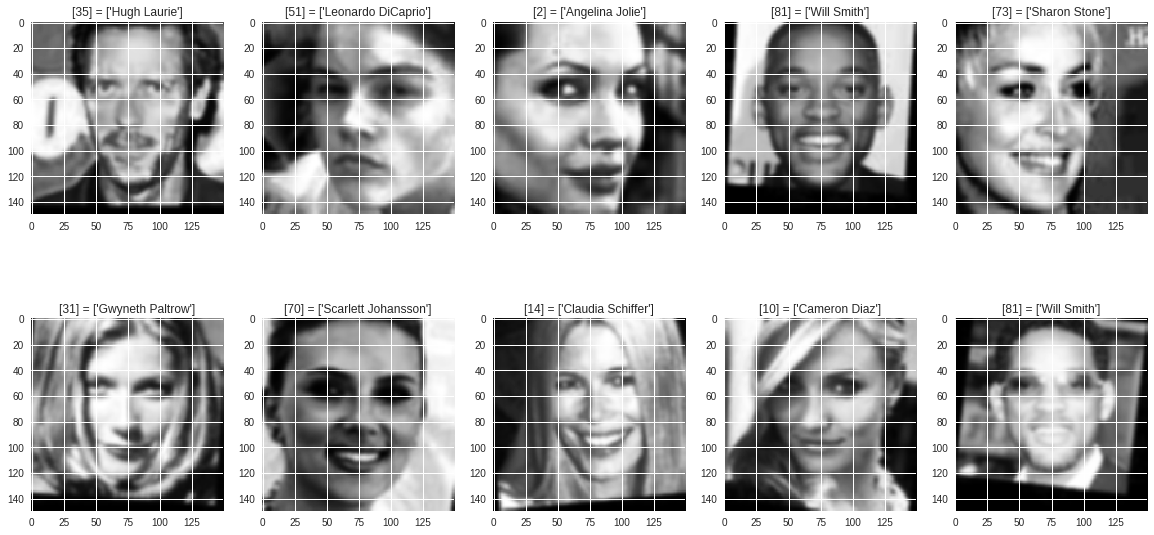

In [16]:
## If setting read_aligned to 0, change the folder

from sklearn.model_selection import train_test_split

def data_gen(batch_size=30, valid_part = 0.2, read_aligned = 1, folder = ALIGNED_DATASET_PATH):
  image_paths = list_files(folder)
  
  train_images, valid_images = train_test_split(image_paths, test_size = valid_part)
  def get_func(image_paths):
    def func():
      while True:

          ## Define the ouput image size desired
          output_img_sz = 150

          ## Take random set of data of size ('batch_size' + 10) to avoid images 
          ## that are unable to load or have no face in it
          sample_dt=random.sample(image_paths,int(batch_size)+10)

          if read_aligned == 1:
              images,labels = read_images_align(sample_dt,1)
          else:
              images,labels = read_images(sample_dt)

          ## Converting them to numpy arrays
          images=np.asarray(images)
          labels=np.asarray(labels)

          flipped_img=[];
          blur_grays = [];

          for image in images:
              ## Converting to grayscale and Equalizing Histogram
              gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
              gray = cv2.equalizeHist(gray)

              ## Resizing the images to output size
              gray = cv2.resize(gray, (output_img_sz, output_img_sz)) 

              ## Adding Gaussian Blur to distort the images a bit
              kernel_size = 7 # Must be an odd number (3, 5, 7...)
              blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
              blur_grays.append(blur_gray)

              ## Flipping the images
              flipped_img.append(np.fliplr(blur_gray))

          ## Appending the Flipped images to 'blur_gray' image array 
          blur_grays = np.append(blur_grays , flipped_img, axis = 0)
          labels = np.append(labels, labels , axis=0)

          ## Choosing a random set of images
          ind = np.random.choice(blur_grays.shape[0], batch_size, replace=False)
          blur_grays=blur_grays[ind,:,:]
          labels=le.transform(labels[ind])

          ## Converting the colorscale to float32
          blur_grays = blur_grays.astype('float32')
          ## Normalizing
          blur_grays /= 255.

          ## Reshaping the image and label arrays and registering as output
          X = np.reshape(blur_grays, [-1,1,output_img_sz,output_img_sz])
          y = np.reshape(labels, [ -1,1])        

          yield X,y
    return func()
  
  return get_func(train_images), get_func(valid_images)
   


### Testing the data generator function

sample_images,sample_labels = next(data_gen(50)[0])
print('Shape of the image array: ', np.shape(sample_images))

## Selecting random image
sample_choice = random.randint(0,9)
sample_img = sample_images[sample_choice]
print('Shape of the image: ', np.shape(sample_img))

## Reshaping to plot the image correctly
sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
print('Shape of image after reshaping: ', np.shape(sample_img))
plt.figure(1)
plt.imshow(sample_img, cmap = 'gray')
plt.title(str(sample_labels[sample_choice])+' = '+str(le.inverse_transform(sample_labels[sample_choice])))


ind = np.random.choice(sample_images.shape[0], 10, replace=False)


fig = plt.figure(2,figsize=[20,10])


for ix, idx in enumerate(ind):
    plt.subplot(2,5,ix+1)
    sample_img = sample_images[idx]
    sample_img = np.reshape(sample_img,[np.shape(sample_img)[2],np.shape(sample_img)[2]])
    plt.imshow(sample_img, cmap = 'gray')
    plt.title(str(sample_labels[idx])+' = '+str(le.inverse_transform(sample_labels[idx])))

In [20]:
## Initial Training -  CNN Base Version 1
dropout_prob=0
l2_norm=0.005
input_shape=(1, sample_img.shape[0],sample_img.shape[1])

identities_count = dirs_count(ALIGNED_DATASET_PATH)


input_layer = Input(shape=input_shape)
# <PASTE MODEL CODE HERE>
X=Conv2D(filters=32,kernel_size=(3,3),activation='relu',data_format="channels_first"\
         ,kernel_regularizer=regularizers.l2(l2_norm))(input_layer)
#X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Conv2D(filters = 32, kernel_size=(3,3), activation='relu',  data_format="channels_first"\
        ,kernel_regularizer=regularizers.l2(l2_norm))(X)
#X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Conv2D(filters = 64, kernel_size=(3,3), activation='relu',  data_format="channels_first"\
        ,kernel_regularizer=regularizers.l2(l2_norm))(X)
#X = BatchNormalization(axis = 1)(X)
X=MaxPooling2D(pool_size=(2,2), data_format="channels_first")(X)
X=Dropout(dropout_prob)(X)

X=Flatten()(X)
X=Dense(64, activation='relu')(X)
X=Dropout(dropout_prob)(X)
model_out = Dense(identities_count, activation="sigmoid")(X)

model = Model(inputs=[input_layer], outputs=model_out)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


## Initial Training
batch_size=32
epochs=4
samp_per_epoch=1000

steps_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

gen_train, gen_valid = data_gen(batch_size)

model.summary()
#model_hist = model.fit_generator(gen_train, steps_per_epoch = steps_per_epoch, nb_epoch=epochs,
#                         validation_data=gen_valid, nb_val_samples=25, max_q_size=25, verbose=1)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1, 150, 150)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 148, 148)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 74, 74)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 74, 74)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 72, 72)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 36, 36)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 36, 36)        0         
__________

In [21]:
## Final Training
batch_size=32
epochs=50
samp_per_epoch=2000

samp_per_epoch = batch_size * ceil(samp_per_epoch/batch_size)

model_hist = model.fit_generator(gen_train, steps_per_epoch = steps_per_epoch,nb_epoch=epochs,
                         validation_data=gen_valid,nb_val_samples=25, max_q_size=25, verbose=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1024, validation_data=<generator..., verbose=1, epochs=50, validation_steps=25, max_queue_size=25)`
  


Epoch 1/50
1024/1024 [==============================] - 78s 76ms/step - loss: 4.0964 - acc: 0.0572 - val_loss: 3.5911 - val_acc: 0.1350
Epoch 2/50
  34/1024 [..............................] - ETA: 47s - loss: 3.4647 - acc: 0.1581

1024/1024 [==============================] - 77s 75ms/step - loss: 3.0399 - acc: 0.2356 - val_loss: 2.9723 - val_acc: 0.2787
Epoch 3/50
 112/1024 [==>...........................] - ETA: 55s - loss: 2.7288 - acc: 0.2902

1024/1024 [==============================] - 77s 75ms/step - loss: 2.5671 - acc: 0.3362 - val_loss: 2.9659 - val_acc: 0.2913
Epoch 4/50
 134/1024 [==>...........................] - ETA: 56s - loss: 2.3930 - acc: 0.3806

1024/1024 [==============================] - 78s 76ms/step - loss: 2.3047 - acc: 0.4014 - val_loss: 2.6201 - val_acc: 0.3500
Epoch 5/50
 143/1024 [===>..........................] - ETA: 56s - loss: 2.2265 - acc: 0.4170

1024/1024 [==============================] - 76s 75ms/step - loss: 2.1635 - acc: 0.4375 - val_loss: 2.4651 - val_acc: 0.3937
Epoch 6/50
 146/1024 [===>..........................] - ETA: 55s - loss: 2.0508 - acc: 0.4683

1024/1024 [==============================] - 77s 75ms/step - loss: 2.0100 - acc: 0.4758 - val_loss: 2.7079 - val_acc: 0.3400
Epoch 7/50
 146/1024 [===>..........................] - ETA: 55s - loss: 1.8783 - acc: 0.5113

1024/1024 [==============================] - 76s 75ms/step - loss: 1.8745 - acc: 0.5082 - val_loss: 2.4214 - val_acc: 0.4288
Epoch 8/50
 148/1024 [===>..........................] - ETA: 55s - loss: 1.8290 - acc: 0.5226

1024/1024 [==============================] - 77s 75ms/step - loss: 1.7894 - acc: 0.5312 - val_loss: 2.3413 - val_acc: 0.4075
Epoch 9/50
 146/1024 [===>..........................] - ETA: 56s - loss: 1.7655 - acc: 0.5387

1024/1024 [==============================] - 76s 74ms/step - loss: 1.7072 - acc: 0.5576 - val_loss: 2.3111 - val_acc: 0.4700
Epoch 10/50
 144/1024 [===>..........................] - ETA: 55s - loss: 1.6504 - acc: 0.5577

1024/1024 [==============================] - 76s 74ms/step - loss: 1.6083 - acc: 0.5769 - val_loss: 2.4118 - val_acc: 0.4375
Epoch 11/50
 147/1024 [===>..........................] - ETA: 55s - loss: 1.5756 - acc: 0.5814

1024/1024 [==============================] - 76s 75ms/step - loss: 1.5265 - acc: 0.5989 - val_loss: 2.3383 - val_acc: 0.4375
Epoch 12/50
 150/1024 [===>..........................] - ETA: 55s - loss: 1.5207 - acc: 0.6044

1024/1024 [==============================] - 76s 74ms/step - loss: 1.4789 - acc: 0.6159 - val_loss: 2.2088 - val_acc: 0.4725
Epoch 13/50
 150/1024 [===>..........................] - ETA: 55s - loss: 1.4497 - acc: 0.6265

1024/1024 [==============================] - 76s 74ms/step - loss: 1.4001 - acc: 0.6356 - val_loss: 2.4952 - val_acc: 0.4425
Epoch 14/50
 146/1024 [===>..........................] - ETA: 56s - loss: 1.3859 - acc: 0.6321

1024/1024 [==============================] - 76s 75ms/step - loss: 1.3462 - acc: 0.6508 - val_loss: 2.2949 - val_acc: 0.4925
Epoch 15/50
 147/1024 [===>..........................] - ETA: 56s - loss: 1.3297 - acc: 0.6511

1024/1024 [==============================] - 76s 74ms/step - loss: 1.3008 - acc: 0.6641 - val_loss: 2.4811 - val_acc: 0.4462
Epoch 16/50
 149/1024 [===>..........................] - ETA: 56s - loss: 1.2585 - acc: 0.6810

1024/1024 [==============================] - 77s 75ms/step - loss: 1.2390 - acc: 0.6813 - val_loss: 2.5563 - val_acc: 0.4662
Epoch 17/50
 147/1024 [===>..........................] - ETA: 56s - loss: 1.2393 - acc: 0.6824

1024/1024 [==============================] - 76s 75ms/step - loss: 1.1900 - acc: 0.6959 - val_loss: 2.5870 - val_acc: 0.4375
Epoch 18/50
 149/1024 [===>..........................] - ETA: 55s - loss: 1.1455 - acc: 0.7028

1024/1024 [==============================] - 77s 75ms/step - loss: 1.1526 - acc: 0.7032 - val_loss: 2.4450 - val_acc: 0.4800
Epoch 19/50
 147/1024 [===>..........................] - ETA: 55s - loss: 1.0866 - acc: 0.7198

1024/1024 [==============================] - 76s 74ms/step - loss: 1.1143 - acc: 0.7175 - val_loss: 2.5670 - val_acc: 0.4437
Epoch 20/50
 147/1024 [===>..........................] - ETA: 55s - loss: 1.1066 - acc: 0.7205

1024/1024 [==============================] - 77s 75ms/step - loss: 1.0702 - acc: 0.7225 - val_loss: 2.7853 - val_acc: 0.4288
Epoch 21/50
 149/1024 [===>..........................] - ETA: 55s - loss: 1.0319 - acc: 0.7353

1024/1024 [==============================] - 76s 75ms/step - loss: 1.0418 - acc: 0.7354 - val_loss: 2.5949 - val_acc: 0.4738
Epoch 22/50
 151/1024 [===>..........................] - ETA: 54s - loss: 1.0299 - acc: 0.7310

1024/1024 [==============================] - 77s 75ms/step - loss: 0.9840 - acc: 0.7486 - val_loss: 2.5906 - val_acc: 0.4725
Epoch 23/50
 147/1024 [===>..........................] - ETA: 56s - loss: 0.9893 - acc: 0.7487

1024/1024 [==============================] - 77s 75ms/step - loss: 0.9575 - acc: 0.7587 - val_loss: 2.5677 - val_acc: 0.4925
Epoch 24/50
 149/1024 [===>..........................] - ETA: 56s - loss: 0.9729 - acc: 0.7647

1024/1024 [==============================] - 77s 75ms/step - loss: 0.9449 - acc: 0.7691 - val_loss: 2.7393 - val_acc: 0.4700
Epoch 25/50
 148/1024 [===>..........................] - ETA: 56s - loss: 0.9244 - acc: 0.7622

1024/1024 [==============================] - 76s 75ms/step - loss: 0.9142 - acc: 0.7708 - val_loss: 2.6649 - val_acc: 0.4587
Epoch 26/50
 146/1024 [===>..........................] - ETA: 55s - loss: 0.8572 - acc: 0.7791

1024/1024 [==============================] - 76s 75ms/step - loss: 0.8782 - acc: 0.7776 - val_loss: 2.9020 - val_acc: 0.4525
Epoch 27/50
 148/1024 [===>..........................] - ETA: 55s - loss: 0.8866 - acc: 0.7798

1024/1024 [==============================] - 77s 75ms/step - loss: 0.8506 - acc: 0.7906 - val_loss: 2.7399 - val_acc: 0.5000
Epoch 28/50
 147/1024 [===>..........................] - ETA: 55s - loss: 0.8236 - acc: 0.7980

1024/1024 [==============================] - 77s 75ms/step - loss: 0.8320 - acc: 0.7990 - val_loss: 2.8102 - val_acc: 0.4412
Epoch 29/50
 148/1024 [===>..........................] - ETA: 56s - loss: 0.8356 - acc: 0.7973

1024/1024 [==============================] - 77s 75ms/step - loss: 0.8119 - acc: 0.8024 - val_loss: 2.9834 - val_acc: 0.4800
Epoch 30/50
 149/1024 [===>..........................] - ETA: 55s - loss: 0.8313 - acc: 0.7951

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7985 - acc: 0.8058 - val_loss: 2.6244 - val_acc: 0.4612
Epoch 31/50
 148/1024 [===>..........................] - ETA: 56s - loss: 0.7700 - acc: 0.8148

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7763 - acc: 0.8131 - val_loss: 2.9869 - val_acc: 0.4375
Epoch 32/50
 148/1024 [===>..........................] - ETA: 55s - loss: 0.7964 - acc: 0.8089

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7695 - acc: 0.8148 - val_loss: 2.9181 - val_acc: 0.4437
Epoch 33/50
 150/1024 [===>..........................] - ETA: 55s - loss: 0.7637 - acc: 0.8190

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7541 - acc: 0.8224 - val_loss: 2.9132 - val_acc: 0.4500
Epoch 34/50
 150/1024 [===>..........................] - ETA: 55s - loss: 0.7224 - acc: 0.8294

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7111 - acc: 0.8338 - val_loss: 3.0252 - val_acc: 0.4487
Epoch 35/50
 150/1024 [===>..........................] - ETA: 55s - loss: 0.7414 - acc: 0.8223

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7157 - acc: 0.8313 - val_loss: 2.9674 - val_acc: 0.4400
Epoch 36/50
 152/1024 [===>..........................] - ETA: 55s - loss: 0.6702 - acc: 0.8477

1024/1024 [==============================] - 77s 75ms/step - loss: 0.7021 - acc: 0.8371 - val_loss: 3.2015 - val_acc: 0.4150
Epoch 37/50
 149/1024 [===>..........................] - ETA: 56s - loss: 0.6869 - acc: 0.8427

1024/1024 [==============================] - 77s 75ms/step - loss: 0.6683 - acc: 0.8476 - val_loss: 3.0236 - val_acc: 0.4500
Epoch 38/50
 152/1024 [===>..........................] - ETA: 55s - loss: 0.6606 - acc: 0.8505

1024/1024 [==============================] - 77s 75ms/step - loss: 0.6728 - acc: 0.8470 - val_loss: 2.7426 - val_acc: 0.4612
Epoch 39/50
 149/1024 [===>..........................] - ETA: 55s - loss: 0.6907 - acc: 0.8393

1024/1024 [==============================] - 76s 74ms/step - loss: 0.6554 - acc: 0.8524 - val_loss: 3.0072 - val_acc: 0.4700
Epoch 40/50
 147/1024 [===>..........................] - ETA: 55s - loss: 0.6552 - acc: 0.8461

1024/1024 [==============================] - 76s 74ms/step - loss: 0.6510 - acc: 0.8501 - val_loss: 3.1134 - val_acc: 0.4587
Epoch 41/50
 152/1024 [===>..........................] - ETA: 55s - loss: 0.6411 - acc: 0.8569

1024/1024 [==============================] - 76s 75ms/step - loss: 0.6274 - acc: 0.8593 - val_loss: 3.1398 - val_acc: 0.4562
Epoch 42/50
 149/1024 [===>..........................] - ETA: 55s - loss: 0.6616 - acc: 0.8473

1024/1024 [==============================] - 76s 74ms/step - loss: 0.6191 - acc: 0.8619 - val_loss: 2.8647 - val_acc: 0.4725
Epoch 43/50
 147/1024 [===>..........................] - ETA: 55s - loss: 0.5973 - acc: 0.8648

1024/1024 [==============================] - 77s 75ms/step - loss: 0.6128 - acc: 0.8636 - val_loss: 3.0601 - val_acc: 0.4637
Epoch 44/50
 148/1024 [===>..........................] - ETA: 56s - loss: 0.6128 - acc: 0.8617

1024/1024 [==============================] - 77s 75ms/step - loss: 0.5981 - acc: 0.8662 - val_loss: 3.0726 - val_acc: 0.4487
Epoch 45/50
 146/1024 [===>..........................] - ETA: 56s - loss: 0.6138 - acc: 0.8624

1024/1024 [==============================] - 77s 75ms/step - loss: 0.5936 - acc: 0.8680 - val_loss: 3.2012 - val_acc: 0.4500
Epoch 46/50
 149/1024 [===>..........................] - ETA: 55s - loss: 0.6095 - acc: 0.8651

1024/1024 [==============================] - 77s 75ms/step - loss: 0.5882 - acc: 0.8726 - val_loss: 3.1760 - val_acc: 0.4550
Epoch 47/50
 148/1024 [===>..........................] - ETA: 56s - loss: 0.5548 - acc: 0.8839

1024/1024 [==============================] - 77s 75ms/step - loss: 0.5726 - acc: 0.8773 - val_loss: 3.1475 - val_acc: 0.4788
Epoch 48/50
 147/1024 [===>..........................] - ETA: 56s - loss: 0.5759 - acc: 0.8697

1024/1024 [==============================] - 76s 75ms/step - loss: 0.5689 - acc: 0.8761 - val_loss: 3.2756 - val_acc: 0.4338
Epoch 49/50
 144/1024 [===>..........................] - ETA: 56s - loss: 0.5444 - acc: 0.8861

1024/1024 [==============================] - 77s 75ms/step - loss: 0.5498 - acc: 0.8835 - val_loss: 3.1923 - val_acc: 0.4525
Epoch 50/50
 146/1024 [===>..........................] - ETA: 55s - loss: 0.5714 - acc: 0.8784

1024/1024 [==============================] - 76s 74ms/step - loss: 0.5528 - acc: 0.8809 - val_loss: 3.2105 - val_acc: 0.4138


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


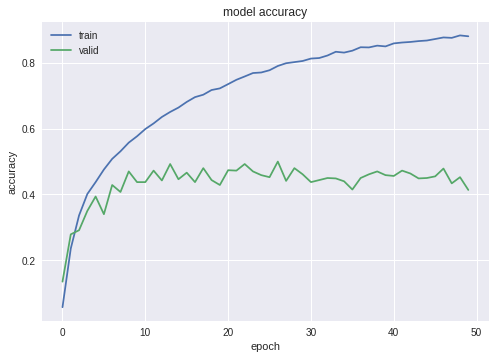

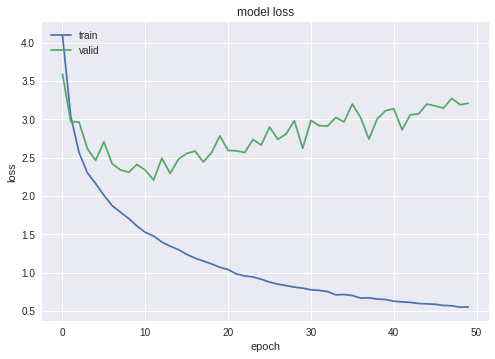

In [22]:
# list all data in history
print(model_hist.history.keys())
# summarize history for accuracy
plt.plot(model_hist.history['acc'])
plt.plot(model_hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()